# Constrained AR-HMM sampling
Sample an autoregressive hidden Markov model subject to a constraint, 
represented as an auxiliary potential.  The joint probability of the 
ARHMM and constraint is,

$$\log p(x, z) = \sum_t \log p(z_t \mid z_{t-1}) + \log p(x_t \mid z_t, x_{t-1}) + c(x_t)$$

where $c(x)$ is the constraint potential, and it is the same for all time.

Can we forward sample $x$ and $z$ in this model? Note that this is the same 
form as the posterior of a switching linear dynamical system, which 
suggests that we will need more elaborate sampling methods.  Suppose the observations are a mixture of Gaussians though. We can define a simple Gibbs sampling algorithm to target the posterior distribution over discrete
and continuous latent states.  Introduce an auxiliary variable $i_t \in \{1, \ldots, M\}$
indicating which mixture component is "observed" at time $t$. Marginalizing
$i_t$ yields the original SLDS.  Conditioned on $i_t$, the latent states
have Gaussian prior and Gaussian likelihood.  How well would this mix?

In [1]:
import os
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
from sklearn.cluster import KMeans
from tqdm.auto import trange

import matplotlib.pyplot as plt
import matplotlib.animation as manimation
%matplotlib inline

import ssm
from ssm.primitives import hmm_sample, lds_sample
from ssm.observations import GaussianObservations
from ssm.init_state_distns import InitialStateDistribution
from ssm.preprocessing import trend_filter, pca_with_imputation

In [2]:
# Make a simple mixture class to implement the constraint potential
class MixtureOfGaussians(object):
    def __init__(self, K, D):
        """
        Initialize a mixture of Gaussians with 
        K clusters and D dimensional observations.
        """
        self.K = K
        self.D = D
        
        self.prior = InitialStateDistribution(K, D, M=0)
        self.observations = GaussianObservations(K, D, M=0)
        
    def fit(self, data):
        # Fit with K-means
        km = KMeans(self.K)
        km.fit(data)
        discrete_states = km.labels_
        
        # Set the prior and observation parameters
        counts = np.bincount(discrete_states, minlength=self.K)
        assert np.all(counts > 1)
        self.prior.log_pi0 = np.log(counts / data.shape[0])
        
        self.observations.mus = km.cluster_centers_
        Sigmas = np.array([np.cov(data[km.labels_ == k].T) for k in range(self.K)])
        self.observations._sqrt_Sigmas = np.linalg.cholesky(Sigmas + 1e-8 * np.eye(self.D))

In [3]:
# Implement the Gibbs sampler
def _gibbs_sample_discrete_states(arhmm, continuous_states):
    """
    Gibbs sample the discrete states given the continuous ones.
    """
    # Initialize input, mask, and tag 
    T = continuous_states.shape[0]
    input = np.zeros((T, 0))
    mask = np.ones_like(continuous_states, dtype=bool)
    tag = None
    
    # Compute potentials
    log_pi0 = arhmm.init_state_distn.log_initial_state_distn(continuous_states, input, mask, tag, None)
    log_Ps = arhmm.transitions.log_transition_matrices(continuous_states, input, mask, tag, None)
    log_likes = arhmm.observations.log_likelihoods(continuous_states, input, mask, tag, None)
    
    # Call the forward filter backward sample code
    return hmm_sample(log_pi0, log_Ps, log_likes)
    
    
def _gibbs_sample_continuous_states(arhmm, discrete_states, indicators, mog, beta=1):
    """
    Gibbs sample the continuous states given the discrete states, 
    the indicators, and the mixture of Gaussian model.
    
    Beta scales the natural parameters of the MoG potential
    J = Sigma^{-1}
    h = Sigma^{-1} \mu = J \mu
    
    When beta = 0, the MoG potential is ignored.
    When beta = 1, the MoG potential is a normalized probability on x
    
    To get the mean parameters, set \mu = J^{-1} h. This is unchanged by beta. 
    
    """
    # Extract the dynamics parameters
    As = arhmm.observations.As[discrete_states[1:]]
    bs = arhmm.observations.bs[discrete_states[1:]]
    Qi_sqrts = np.linalg.cholesky(np.linalg.inv(arhmm.observations.Sigmas))
    Qi_sqrts = Qi_sqrts[discrete_states[1:]]
    
    # Extract the observation potentials
    ms = mog.observations.mus[indicators]
    Ri_sqrts = np.linalg.cholesky(np.linalg.inv(mog.observations.Sigmas))
    Ri_sqrts = Ri_sqrts[indicators]
    
    # Call the forward filter backward sample code
    return lds_sample(As, bs, Qi_sqrts, ms, 1e-4 * np.eye(arhmm.D) + np.sqrt(beta) * Ri_sqrts)
    
    
def _gibbs_sample_indicators(continuous_states, mog, beta=1):
    """
    Gibbs sample the indicator variables given the continuous states
    and the mixture of Gaussian model.
    """
    # Initialize input, mask, and tag 
    T = continuous_states.shape[0]
    input = np.zeros((T, 0))
    mask = np.ones_like(continuous_states, dtype=bool)
    tag = None
    
    # Compute potentials
    log_pi0 = mog.prior.log_initial_state_distn(continuous_states, input, mask, tag, None)
    
    # Scale likelihood by beta
    tmp = mog.observations._sqrt_Sigmas.copy()
    mog.observations._sqrt_Sigmas /= (np.sqrt(beta) + 1e-4)
    log_likes = mog.observations.log_likelihoods(continuous_states, input, mask, tag, None)
    mog.observations._sqrt_Sigmas = tmp
    
    # Compute posterior
    log_posterior = log_pi0 + log_likes
    posterior = np.exp(log_posterior - logsumexp(log_posterior, axis=1, keepdims=True))
    
    # Sample
    return np.array([npr.choice(mog.K, p=p) for p in posterior])

def gibbs_sample_constrained_arhmm(T, arhmm, mog, 
                                   num_samples=25,
                                   num_burnin=100, 
                                   burnin_schedule=None):
    """
    Gibbs sample an ARHMM with an extra mixture of Gaussians observation potential.
    """
    # Initialize the discrete and continuous states randomly
    # discrete_states = npr.choice(arhmm.K, size=T)
    # continuous_states = npr.randn(T, arhmm.D)
    
    # Initialize with an unconstrained sample from the arhmm
    discrete_states, continuous_states = arhmm.sample(T)
    indicators = -1 * np.ones(T, dtype=int) 
    
    # Initialize outputs
    discrete_state_smpls = [discrete_states]
    continuous_state_smpls = [continuous_states]
    indicator_smpls = [indicators]
    
    # Initialize the annealing schedule
    if burnin_schedule is None:
        betas = np.ones(num_burnin)
    elif isinstance(burnin_schedule, np.ndarray):
        assert burnin_schedule.shape == (num_burnin,) and np.all(burnin_schedule >= 0)
    elif isinstance(burnin_schedule, str) and burnin_schedule.lower() == "linear":
        # use a linear schedule by default
        betas = np.linspace(0, 1, num_burnin)
    elif isinstance(burnin_schedule, str) and burnin_schedule.lower() == "sigmoidal":
        # sigmoidal schedule puts more steps near the endpoints
        t = np.arange(1,num_burnin+1).astype(np.float)
        delta = 4.0
        logistic = lambda x: np.exp(x) / (1+np.exp(x))
        betatildes = logistic(delta*(2*t/num_burnin - 1))
        betas = (betatildes - betatildes[0]) / (betatildes[-1] - betatildes[0])
    else:
        raise Exception("Invalid burnin schedule")
    
    # Run the Gibbs sampler
    for itr in trange(num_burnin + num_samples):
        beta = betas[itr] if itr < num_burnin else 1
        indicators = _gibbs_sample_indicators(continuous_states, mog, beta=beta)
        continuous_states = _gibbs_sample_continuous_states(arhmm, discrete_states, indicators, mog, beta=beta)
        discrete_states = _gibbs_sample_discrete_states(arhmm, continuous_states)
        
        # Save the samples
        indicator_smpls.append(indicators)
        discrete_state_smpls.append(discrete_states)
        continuous_state_smpls.append(continuous_states)
        
    return discrete_state_smpls, continuous_state_smpls, indicator_smpls

# Try it out on the worm data

In [4]:
# Load up the worm data
from zimmer.io import load_kato_data

tmp = os.getcwd()
os.chdir("/Users/scott/Projects/zimmer")
ys, masks, z_trues, z_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
os.chdir(tmp)

# Preprocess the worm data
ys = [trend_filter(y) for y in ys]

K_true = len(z_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

# Run factor analysis to get low dimensional continuous states
D = 10
pca, xs, lls = pca_with_imputation(D, ys, masks, num_iters=20)

Only including named neurons.
59 neurons across all 5 worms


# Fit a MoG to one of the worms

In [5]:
x = xs[-1]

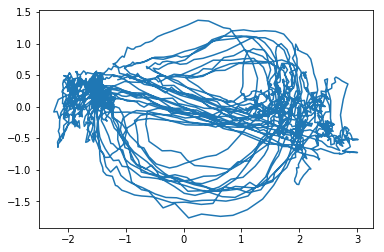

In [6]:
plt.plot(x[:,0], x[:,1])

In [7]:
mog = MixtureOfGaussians(100, D)
mog.fit(x)

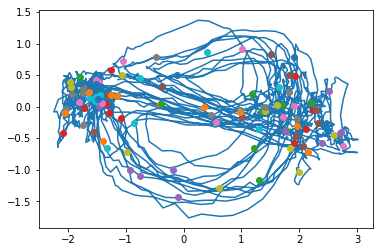

In [8]:
plt.plot(x[:,0], x[:,1])
for mu in mog.observations.mus:
    plt.plot(mu[0], mu[1], 'o')

In [9]:
arhmm = ssm.HMM(K=8, D=D, observations="ar")
arhmm.fit(x)

[51548.651895991556,
 51548.651895991556,
 59903.197807672856,
 60152.1425529228,
 60222.765700515265,
 60278.54552934463,
 60306.35718036431,
 60317.549735070104,
 60324.45531005418,
 60333.02223079249,
 60343.87380914786,
 60348.97770035187,
 60354.0093803267,
 60355.47156949344,
 60357.705073633944,
 60361.516256568335,
 60365.221825932706,
 60368.81922711351,
 60369.77079599689,
 60370.17950084366,
 60370.41830796857,
 60370.614828594924,
 60370.95465209777,
 60372.01097976675,
 60373.1611729726,
 60373.40180479879,
 60373.7285730157,
 60374.8316779261,
 60377.246785167205,
 60380.79679524479,
 60383.23567253077,
 60385.591178295195,
 60386.59010821113,
 60387.89435511014,
 60390.28309513961,
 60394.44818424902,
 60400.202850298854,
 60402.84784396758,
 60410.308267597386,
 60416.964148791405,
 60419.64254491055,
 60423.41744416161,
 60425.59542553695,
 60427.06125356071,
 60429.034004702975,
 60430.692640933245,
 60433.704956932765,
 60438.478788144304,
 60442.7772256055,
 60443.1

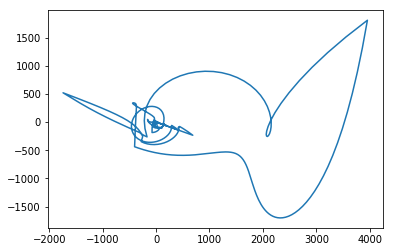

In [10]:
z_smpl, x_smpl = arhmm.sample(T=3000)
plt.plot(x_smpl[:,0], x_smpl[:, 1])

In [11]:
def sample(T=3000,
           num_samples=25,
           num_burnin=100, 
           schedule=None, 
           filename="samples.mp4"):
    
    print("Running Gibbs sampler")
    z_smpls, x_smpls, i_smpls = gibbs_sample_constrained_arhmm(T, arhmm, mog, 
                                                               num_samples=num_samples,
                                                               num_burnin=num_burnin, 
                                                               burnin_schedule=schedule)
        
    # Plot the discrete states
    plt.figure()
    plt.imshow(z_smpls, aspect="auto")
    plt.colorbar()
    
    # Plot the indicators
    plt.figure()
    plt.imshow(i_smpls, aspect="auto")
    plt.colorbar()
    
    # Make a movie
    print("Making movie")
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title="constrained arhmm samples")
    writer = FFMpegWriter(fps=5, bitrate=-1, metadata=metadata)

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Initialize the plots
    ax1.plot(x[:,0], x[:,1], color='lightgray', alpha=1)
    h1 = ax1.plot(x_smpls[0][:,0], x_smpls[0][:,1])[0]
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-2, 2)
    ax1.set_xlabel("dim 1")
    ax1.set_ylabel("dim 2")

    # Initialize the plots
    ax2.plot(x - 3 * np.arange(D), color='lightgray', alpha=1)
    h2 = ax2.plot(x_smpls[0] - 3 * np.arange(D))
    ax2.set_xlim(0, 3000)
    ax2.set_ylim(-3*D, 3)
    ax2.set_yticks(-3 * np.arange(D))
    ax2.set_yticklabels(np.arange(D)+1)
    ax2.set_ylabel("latent dim")
    ax2.set_xlabel("time")

    fig.suptitle("Sample 0")

    def update_frame(i):
        h1.set_data((x_smpls[i][:,0], x_smpls[i][:,1]))
        for d in range(D):
            h2[d].set_data((np.arange(3000), x_smpls[i][:,d] - 3 * d))
        fig.suptitle("Sample {}".format(i))

    with writer.saving(fig, filename, 300):
        for i in trange(num_burnin + num_samples):
            update_frame(i)
            writer.grab_frame()


Running Gibbs sampler



Making movie


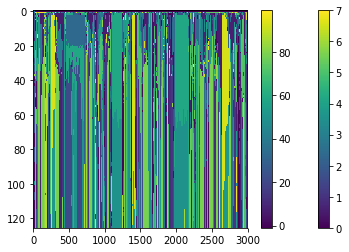

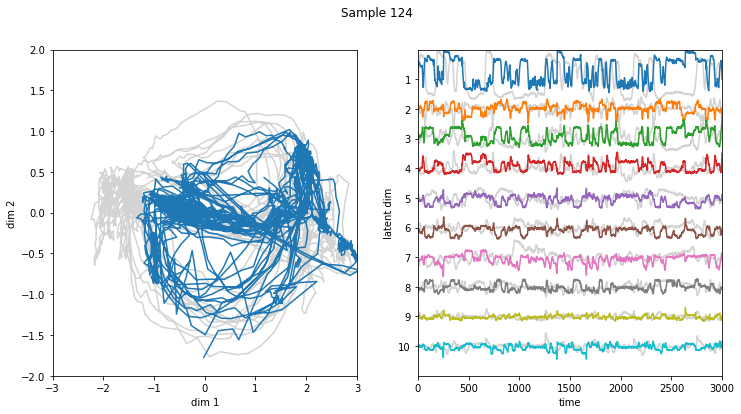

In [12]:
sample(schedule="sigmoidal", filename="sigmoidal1.mp4")

Running Gibbs sampler



Making movie


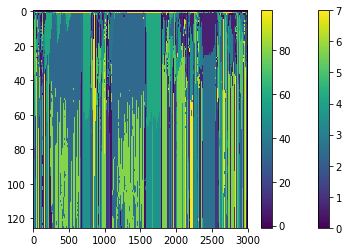

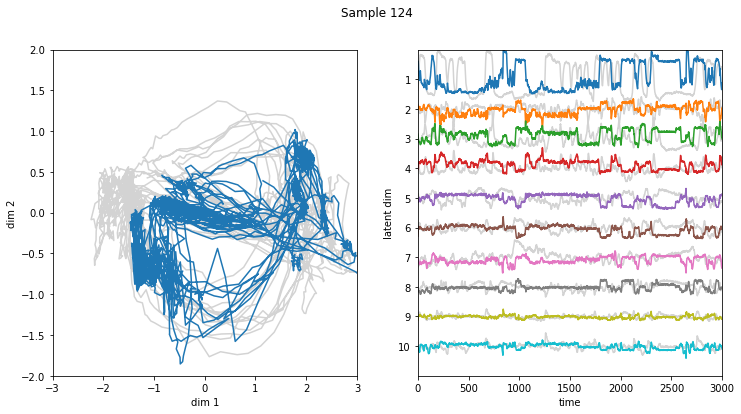

In [13]:
sample(schedule="sigmoidal", filename="sigmoidal2.mp4")

Running Gibbs sampler



Making movie


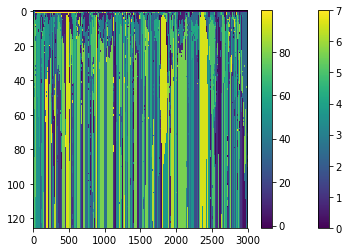

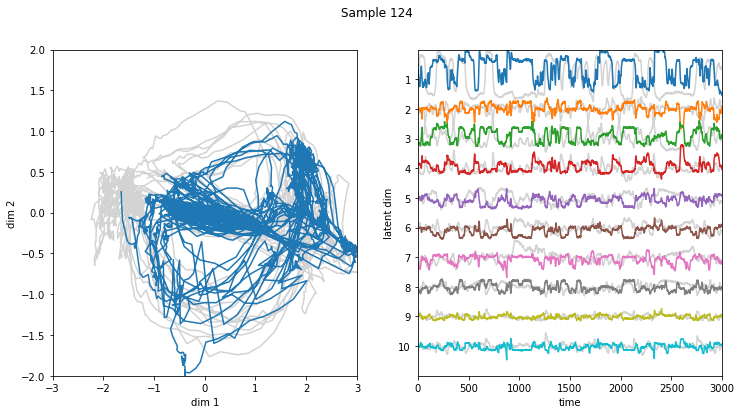

In [14]:
sample(schedule="linear", filename="linear1.mp4")

Running Gibbs sampler



Making movie


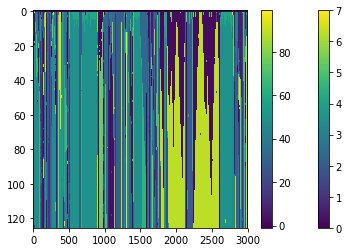

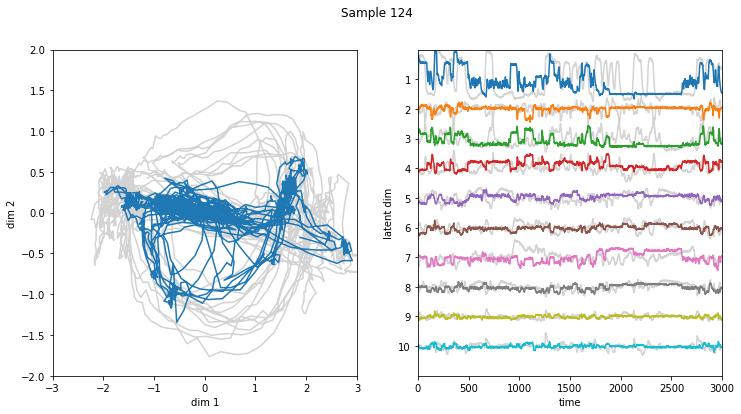

In [15]:
sample(schedule=None, filename="none1.mp4")